## ST Assignement 1: 

##### Hocine Samy
##### Bazaz Jazayeri Samuel 

### Setup

**Imports**

In [1]:
############
# Packages #
############
import random
import numpy as np
import matplotlib.pyplot as plt
from loadmydata.load_human_locomotion import (
    load_human_locomotion_dataset,
    get_code_list,
)

from dtw import dtw
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score

import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

from typing import List, Dict

##############
# glocal var #
##############
seed = 0
pio.renderers.default = "plotly_mimetype+notebook"

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



C:\Users\samud\anaconda3\lib\site-packages\cupy\_environment.py:447: UserWarning: 
--------------------------------------------------------------------------------

  CuPy may not function correctly because multiple CuPy packages are installed
  in your environment:

    cupy-cuda101, cupy-cuda12x

  Follow these steps to resolve this issue:

    1. For all packages listed above, run the following command to remove all
       existing CuPy installations:

         $ pip uninstall <package_name>

      If you previously installed CuPy via conda, also run the following:

         $ conda uninstall cupy

    2. Install the appropriate CuPy package.
       Refer to the Installation Guide for detailed instructions.

         https://docs.cupy.dev/en/stable/install.html

--------------------------------------------------------------------------------

  warnings.warn(f'''


**Utility functions**

In [3]:
def fig_ax(figsize=(15, 5)):
    fig, ax = plt.subplots(figsize=figsize)
    ax.autoscale(enable=True, axis='x', tight=True)
    return fig, ax

# Spectral feature

## Question 6

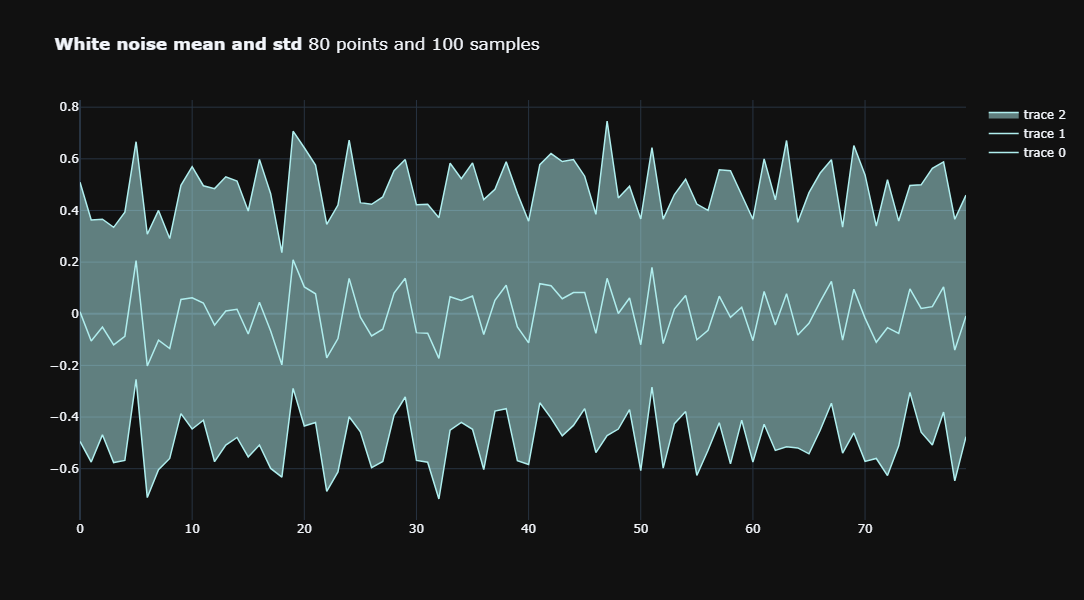

In [5]:
def sample_wnoise(n_points: int, n_sample: int) -> np.ndarray:
    """
    Generate a sample of standard strong white noise.

    Args:
        n_points (int): The number of data points in each sample.
        n_sample (int): The number of samples to generate.

    Returns:
        np.ndarray: A NumPy array containing random noise with the specified dimensions.
    """
    return np.random.normal(size = n_points*n_sample).reshape((n_sample, n_points))

def plot_mean_std(sample: np.ndarray, title: str = "<b>Confidence Interval</b>", x=None) -> None:
    """
    Plot the mean and confidence interval of a sample.

    Args:
        sample (np.ndarray): A NumPy array containing the data sample.
        title (str): The title of the plot (default is "<b>Confidence Interval</b>").

    Returns:
        None
    """
    if x is None:
        x = np.arange(sample.shape[1])
        
    mean = sample.mean(axis = 0)
    std = sample.std(axis = 0)
    fig = go.Figure(
        layout=go.Layout(
            height=600, 
            width=800, 
            template = "plotly_dark", 
            title = title
    )) 
    
    fig.add_traces([
    go.Scatter(x=x, y=mean, line=dict(width=1.5, color="paleturquoise")),
    go.Scatter(
        x=x, y=mean + 0.5 * std,
        line=dict(width=1.5, color="paleturquoise"),
        opacity = 0.6,
    ),
    go.Scatter(
        x=x, y=mean - 0.5 * std,
        fill="tonexty",
        line=dict(width=1.5, color="paleturquoise"),
        opacity = 0.6,
    )])
    fig.show() 

plot_mean_std(sample_wnoise(80, 100), title ="<b>White noise mean and std</b> 80 points and 100 samples")

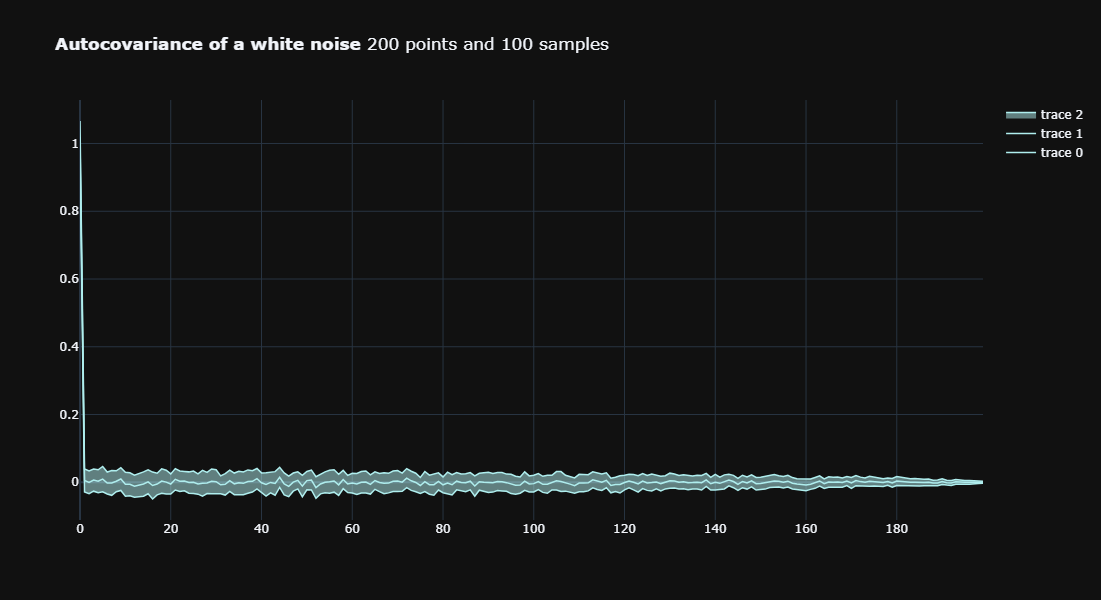

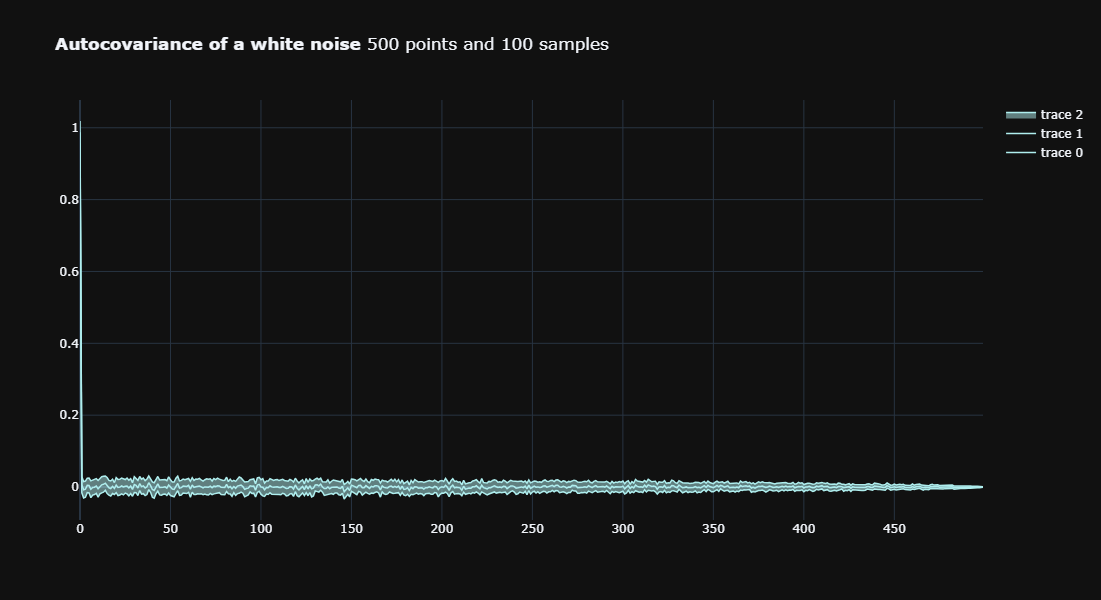

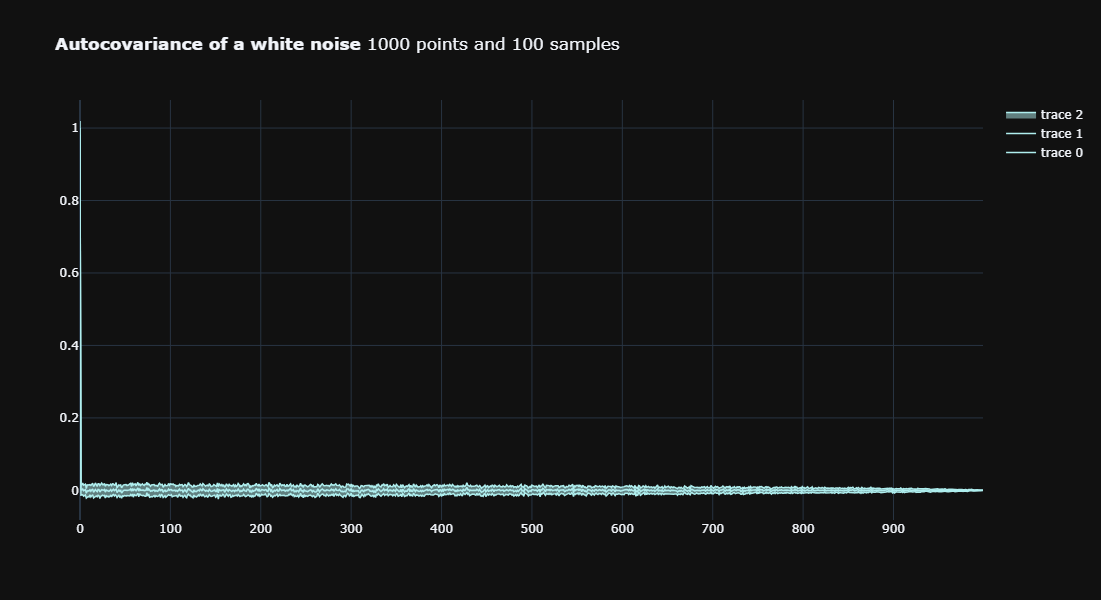

In [6]:
def get_autocovariances(samples: np.ndarray) -> np.ndarray:
    """
    Calculate the autocovariances of a set of samples.

    Args:
        samples (np.ndarray): A 2D NumPy array where each row represents a sample, 
                             and columns represent data points.

    Returns:
        np.ndarray: A 2D NumPy array containing the autocovariances of the samples.
    """
    n_points = samples.shape[1]
    autocovariances = np.zeros((len(samples), n_points))
    for tau in range(n_points):
        prod_mat = samples[:, :n_points-tau]
        prod_mat = prod_mat*samples[:, tau:]
        autocovariances[:, tau] = prod_mat.sum(axis = 1)
    
    autocovariances = autocovariances/n_points
    return autocovariances

# Plot autocovariance of white noises
for n_points in [200, 500, 1000]:
    wn_sample = sample_wnoise(n_points, 100)
    autocov = get_autocovariances(wn_sample)
    plot_mean_std(autocov, title =f"<b>Autocovariance of a white noise</b> {n_points} points and 100 samples")

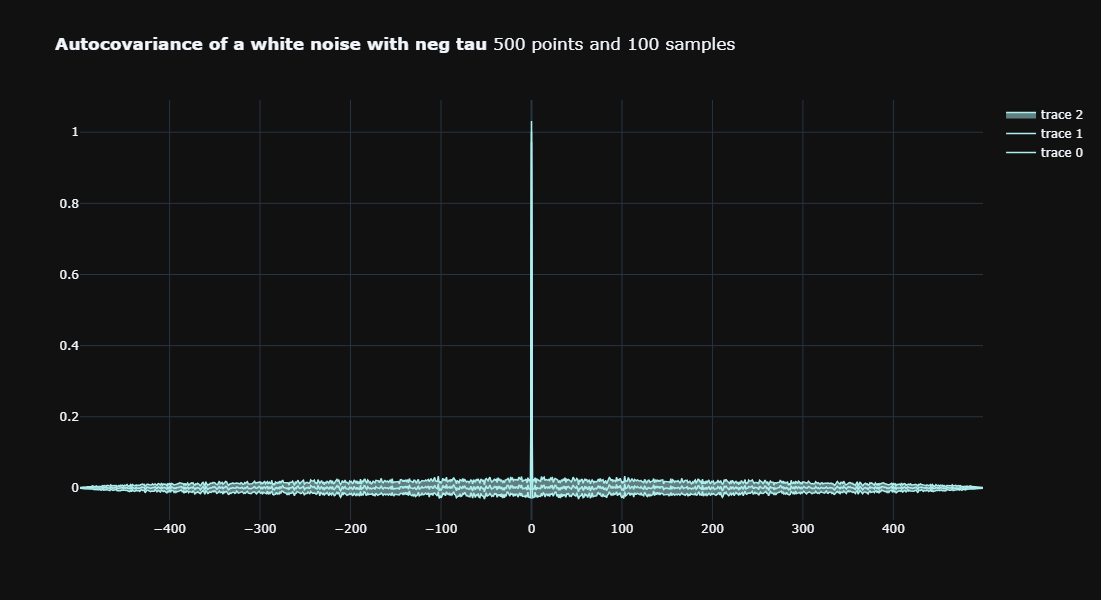

In [7]:
# test auto covariance with negaive tau
n_points = 500
samples = sample_wnoise(n_points, 100)

autocovariances = get_autocovariances(samples)
autocov_with_neg_tau = np.zeros((len(samples), 2*n_points-1))
autocov_with_neg_tau[:,:n_points] = np.flip(autocovariances)
autocov_with_neg_tau[:,n_points:] = autocovariances[:,1:]
plot_mean_std(autocov_with_neg_tau, 
              title =f"<b>Autocovariance of a white noise with neg tau</b> {n_points} points and 100 samples",
              x = np.arange(-n_points+1, n_points)
             )


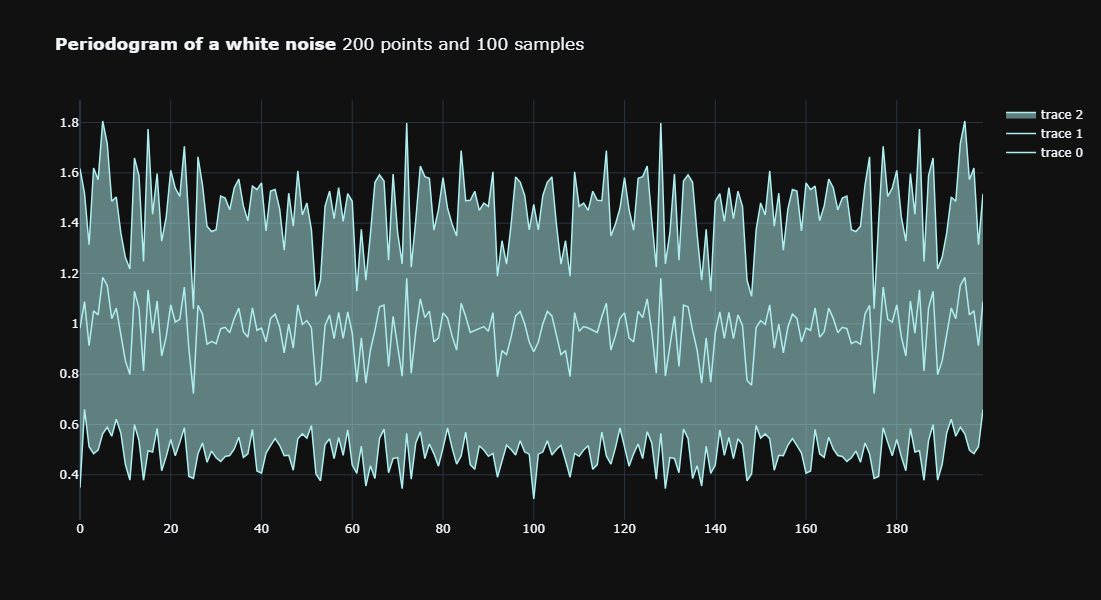

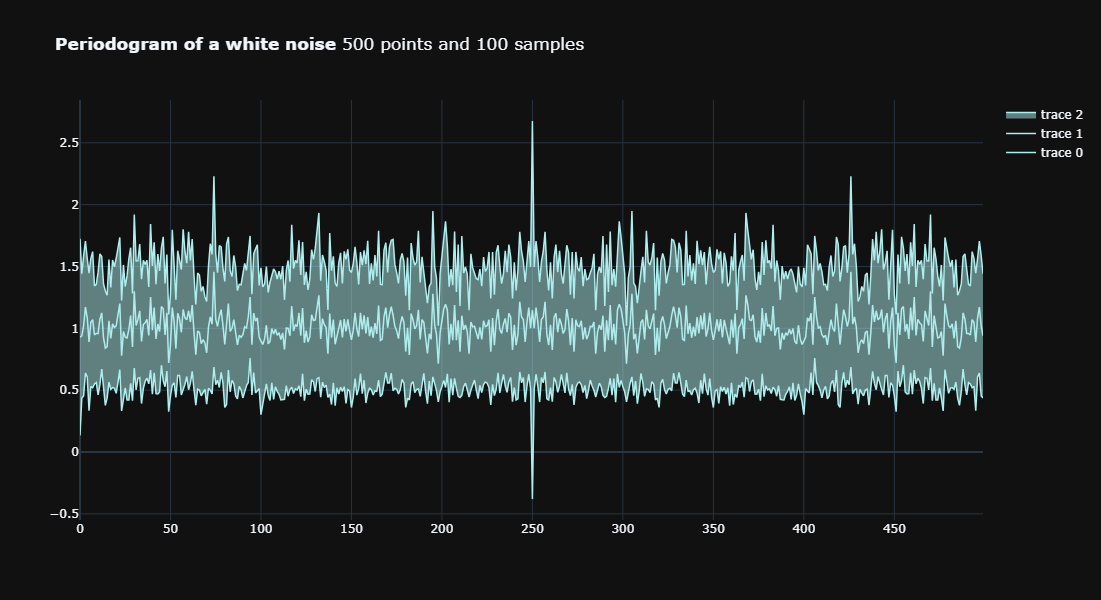

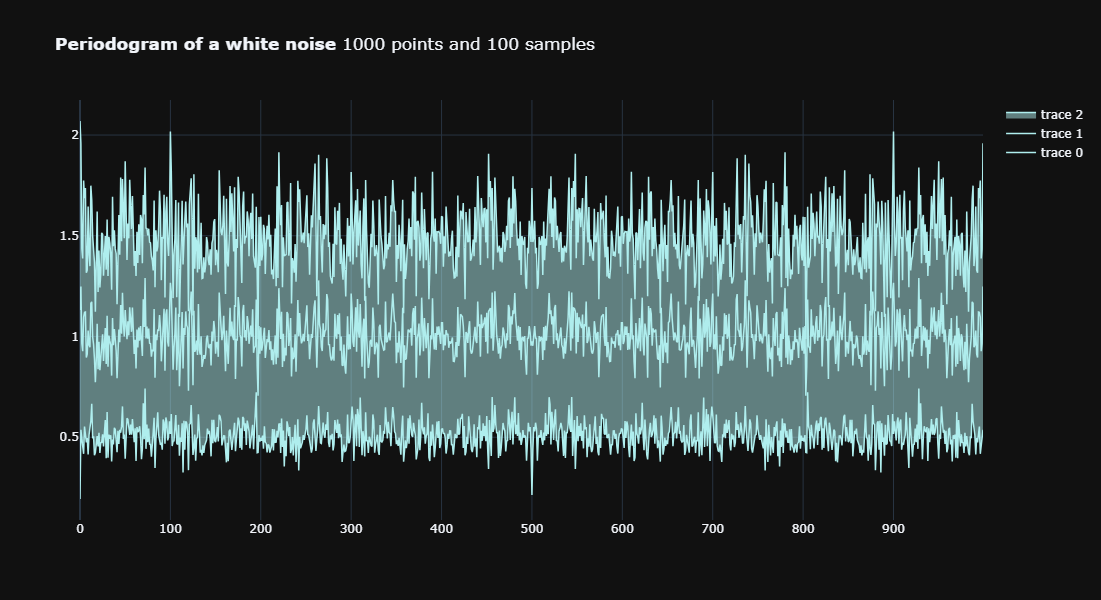

In [8]:
def get_periodograms(samples: np.ndarray) -> np.ndarray:
    """
    Calculate the periodograms of a set of samples.

    Args:
        samples (np.ndarray): A 2D NumPy array where each row represents a sample, 
                             and columns represent data points.

    Returns:
        np.ndarray: A 2D NumPy array containing the periodograms of the samples.
    """
    n_points = samples.shape[1]
    periodograms = np.zeros((len(samples), n_points))
    autocovariances = get_autocovariances(samples)
    angles0 = (2*np.pi/n_points)*np.arange(1, n_points)
    for k in range(n_points):
        periodograms[:, k] = autocovariances[:,0]+np.sum(autocovariances[:,1:]*2*np.cos(k*angles0), axis = 1)
    return periodograms

# Plot periodogram of white noises
for n_points in [200, 500, 1000]:
    wn_sample = sample_wnoise(n_points, 100)
    
    perio = get_periodograms(wn_sample)
    plot_mean_std(perio, 
                  title =f"<b>Periodogram of a white noise</b> {n_points} points and 100 samples", 
                  x = np.arange(n_points)
                 )

## Question 9

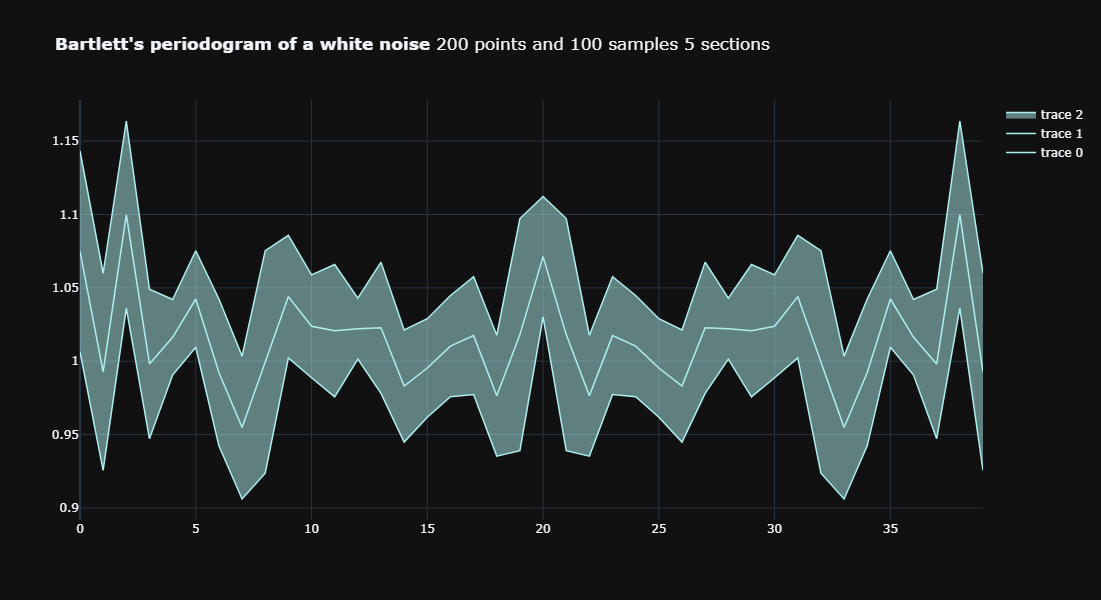

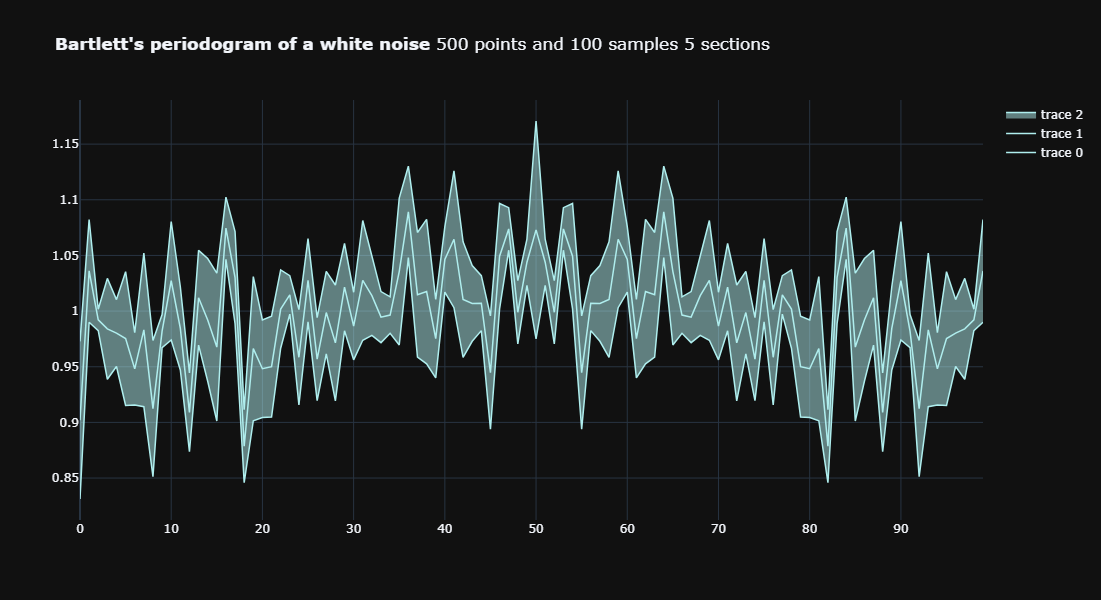

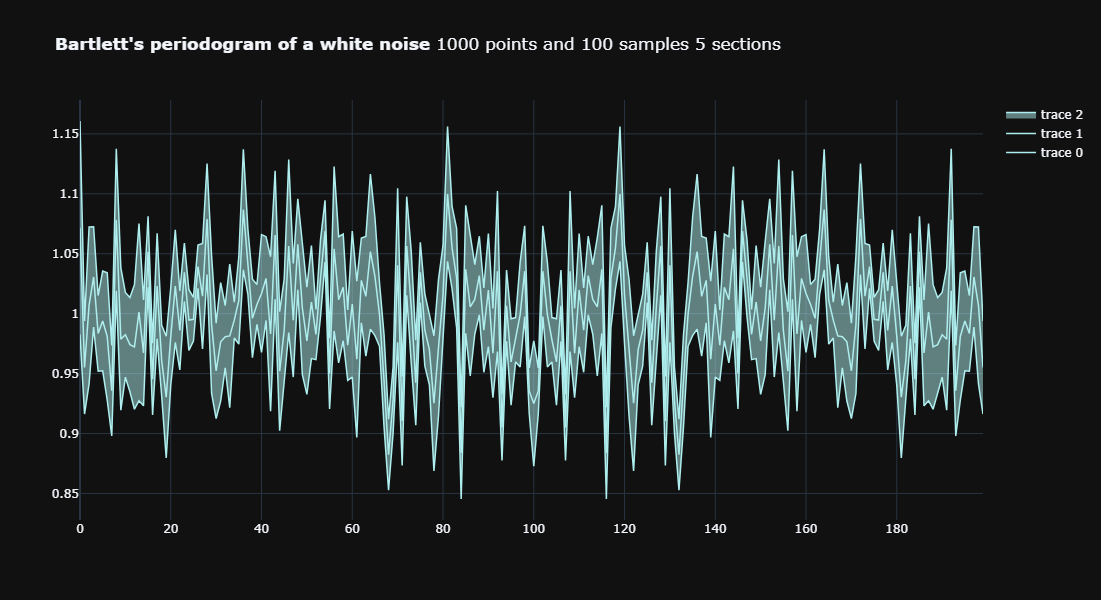

In [9]:
def get_bartlett_periodograms(samples: np.ndarray, n_sections: int = 5) -> np.ndarray:
    """
    Calculate the Bartlett periodograms of a set of samples.

    Args:
        samples (np.ndarray): A 2D NumPy array where each row represents a sample, 
                             and columns represent data points.
        n_sections (int): The number of sections to split the samples for Bartlett periodogram estimation.

    Returns:
        np.ndarray: A 2D NumPy array containing the Bartlett periodograms.
    """
    lst_perio = [get_periodograms(splt.T) for  splt in np.split(samples.T,5)] 
    
    return np.mean(lst_perio, axis = 1)

# Plot Bartlett's periodogram of white noises
n_sections=5
for n_points in [200, 500, 1000]:
    wn_sample = sample_wnoise(n_points, 100)
    perio = get_bartlett_periodograms(wn_sample, n_sections)
    plot_mean_std(perio, 
                  title =f"<b>Bartlett's periodogram of a white noise</b> {n_points} points and 100 samples {n_sections} sections", 
                  x = np.arange(n_points)
                 )

# Dynamic time warping (DTW)

## Data

This data set consists of signals collected with inertial measurement units (accelerometer+gyroscope), from 230 subjects undergoing a fixed protocol:
- standing still,
- walking 10 m,
- turning around,
- walking back,
- stopping.

In this assignment, we only consider the vertical acceleration of the left foot and all signals are truncated to 20 seconds (as a result, they all have same length). Signals are sampled at 100 Hz.

The measured population is composed of healthy subjects as well as patients with neurological or orthopedic disorders.

The start and end time stamps of thousands of footsteps are available.

The data are part of a larger data set described in [1].

[1] Truong, C., Barrois-Müller, R., Moreau, T., Provost, C., Vienne-Jumeau, A., Moreau, A., Vidal, P.-P., Vayatis, N., Buffat, S., Yelnik, A., Ricard, D., & Oudre, L. (2019). A data set for the study of human locomotion with inertial measurements units. Image Processing On Line (IPOL), 9.

**The task** is to classify footsteps in healthy/non-healthy.

The following cell defines the training set `(X_train, y_train)` and testing set `(X_test, y_test)`.

In [10]:
subset_indexes_train = [95, 619, 441, 149, 951, 803, 214, 34, 37, 630]
subset_indexes_test = [683, 259, 59, 387, 634]

code_list = get_code_list()

X_train = list()  # list of footstep signals
y_train = list()  # list of pathologies (the "labels")

for code in np.take(code_list, subset_indexes_train):
    single_trial = load_human_locomotion_dataset(code)
    signal = single_trial.signal.LAZ.to_numpy()  # keeping only one dimension (from the left sensor)
    steps = single_trial.left_steps
    pathology = single_trial.metadata["PathologyGroup"]
    label = 0 if pathology=="Healthy" else 1  # 0: healthy, 1: non-healthy
    for (start, end) in steps:
        X_train.append(signal[start:end])
        y_train.append(label)

        
X_test = list()  # list of footstep signals
y_test = list()  # list of pathologies (the "labels")

for code in np.take(code_list, subset_indexes_test):
    single_trial = load_human_locomotion_dataset(code)
    signal = single_trial.signal.LAZ.to_numpy()  # keeping only one dimension (from the left sensor)
    steps = single_trial.left_steps
    pathology = single_trial.metadata["PathologyGroup"]
    label = 0 if pathology=="Healthy" else 1  # 0: healthy, 1: non-healthy
    for (start, end) in steps:
        X_test.append(signal[start:end])
        y_test.append(label)

## Question 10

In [11]:
#################################
# labels and features dimension #
#################################
print("y train values",np.unique(y_train))
print("y test values",np.unique(y_test))

print("X train dimensions", len(X_train), len(X_train[0]))
print("X test dimensions", len(X_test), len(X_test[0]))

y train values [0 1]
y test values [0 1]
X train dimensions 168 80
X test dimensions 88 147


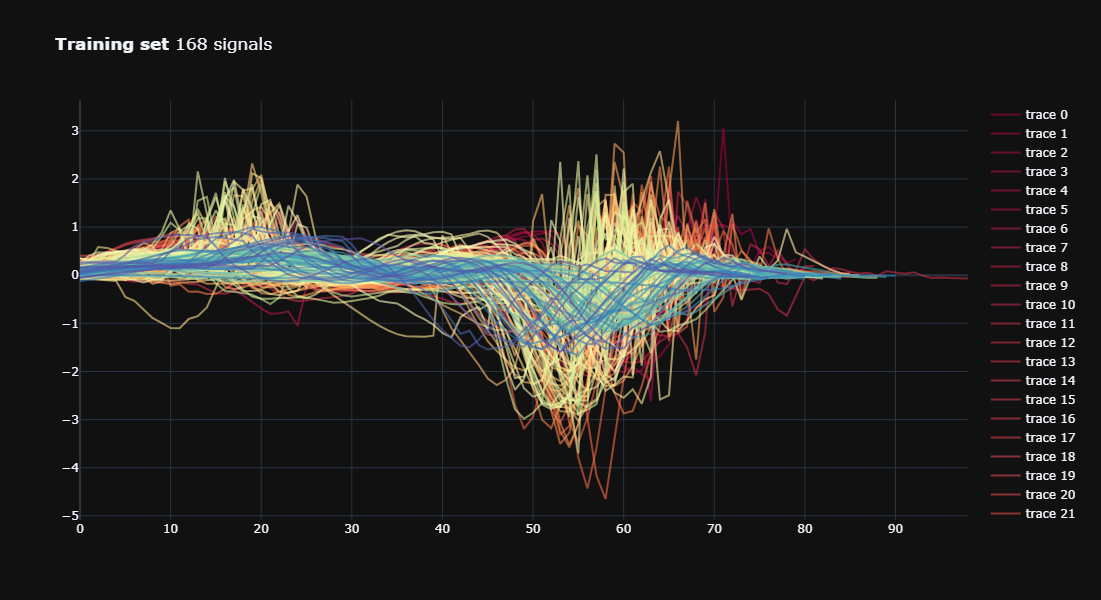

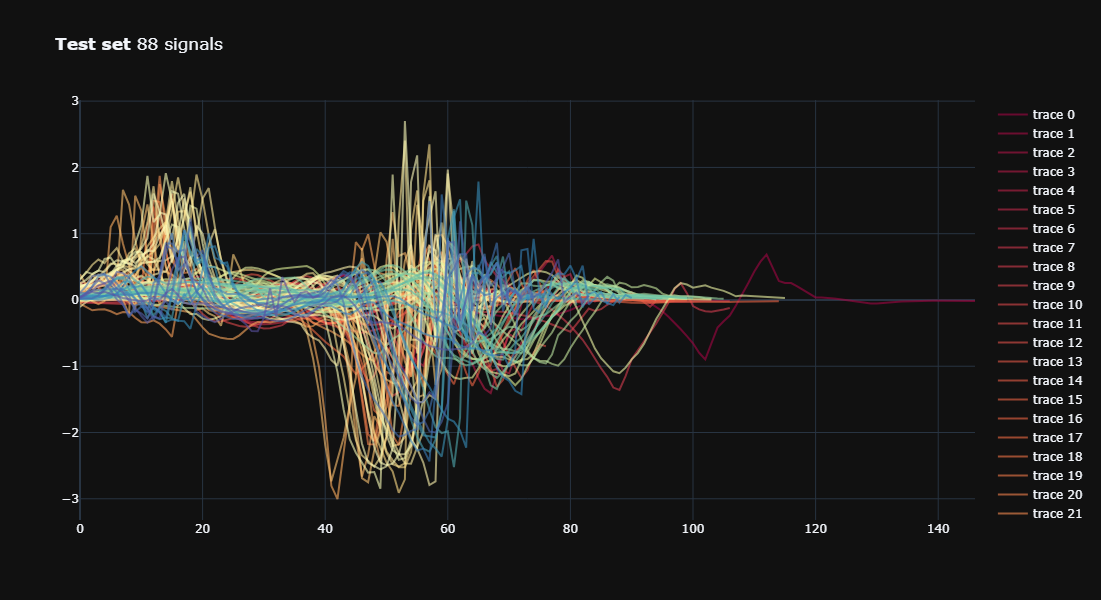

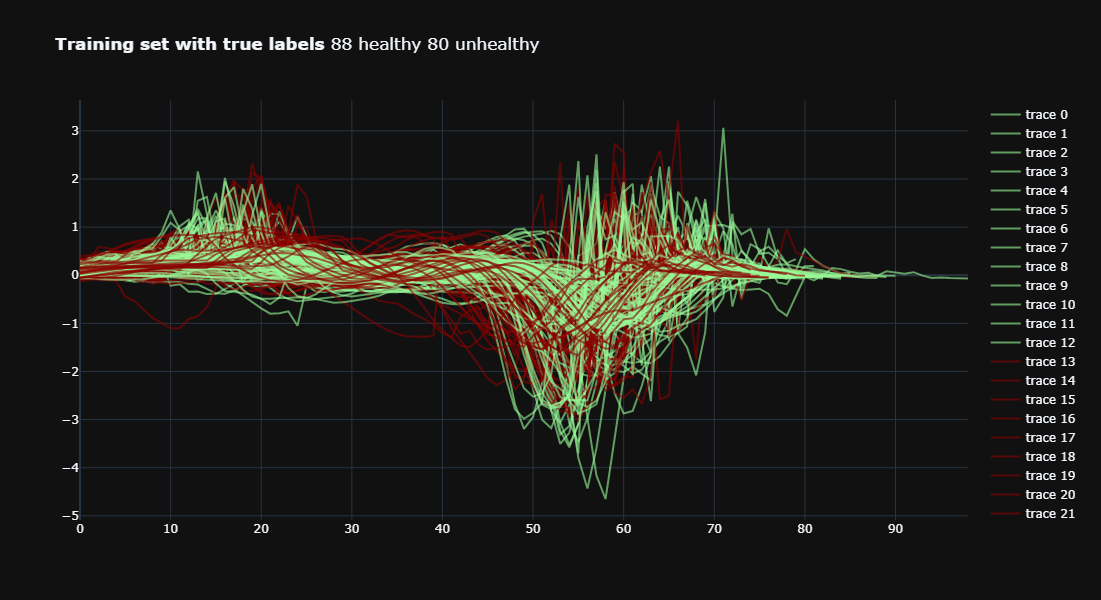

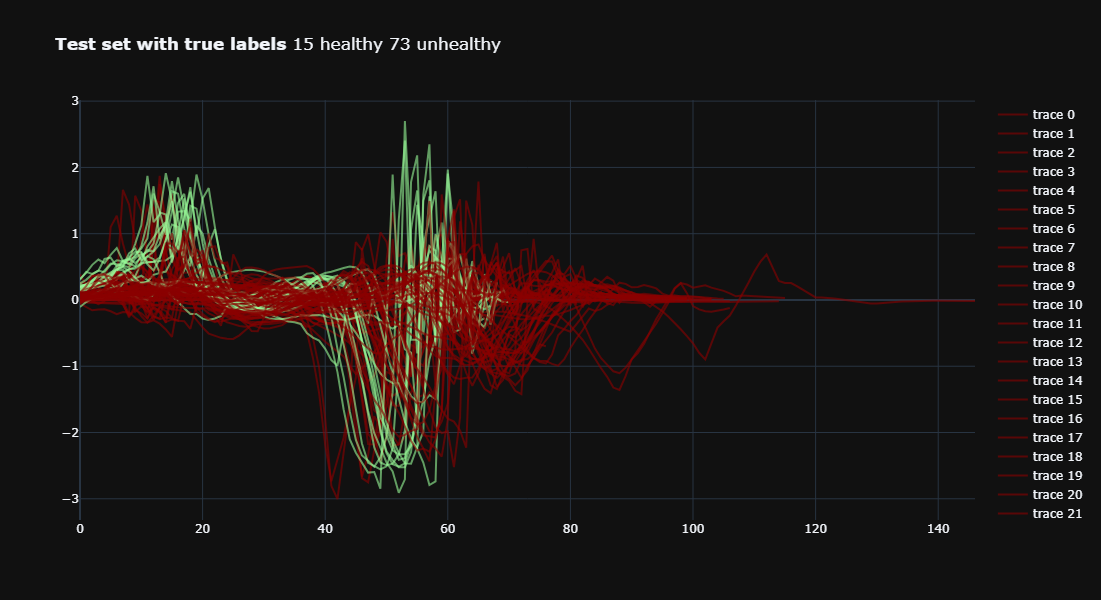

In [12]:
###########################
# Raw data visualizations #
###########################

def plot_all_st(X, clustering=None, title="<b>Signals</b>"):
    """
    Plot multiple signals in a single interactive Plotly figure.

    Args:
        X (list of arrays): A list of signal arrays to be plotted.
        clustering (list or None, optional): A list of cluster assignments for each signal. 
            If provided, signals will be color-coded by cluster. Default is None.
        title (str, optional): The title of the plot. Default is "<b>Signals</b>".

    Returns:
        None: Displays an interactive Plotly figure with the plotted signals.
    """
    
    fig = go.Figure(
        layout=go.Layout(
            height=600, 
            width=800, 
            template = "plotly_dark", 
            title = title
    ))
        
    if clustering:
        pal = ["palegreen", "darkred"]
    else:
        pal = sns.color_palette("Spectral", len(X)).as_hex()

    for i in range(len(X)):
        if clustering:
            color = pal[clustering[i]]
        else:
            color = pal[i]
            
        fig.add_trace(go.Scatter(y=X[i], 
                                 mode="lines", 
                                 line=dict(
                                     width=2,
                                     color=color,
                                 ),
                                 opacity = 0.6
                                ))
    fig.show()    


plot_all_st(X_train, clustering = None, title = f"<b>Training set</b> {len(X_train)} signals")
plot_all_st(X_test, clustering = None, title = f"<b>Test set</b> {len(X_test)} signals")

plot_all_st(X_train, clustering = y_train, 
            title = f"<b>Training set with true labels</b> {y_train.count(0)} healthy {y_train.count(1)} unhealthy")
plot_all_st(X_test, clustering = y_test, 
            title = f"<b>Test set with true labels</b> {y_test.count(0)} healthy {y_test.count(1)} unhealthy")

The bases seems ordered by the shapes, and the test set is unbalanced.

In [13]:
#####################
#  data processing  #
#####################
# NaN values replacement from the signale in order to avoid exceptions
nan_val = -10000

def reformat_signals(X, max_lenghts):
    """
    Reformat a list of signals to a common length with optional padding.

    Args:
        X (list of arrays): A list of signal arrays to be reformatted.
        max_lengths (int): The maximum length to which the signals will be reformatted.
        nan_val (float, optional): The value to use for padding when extending signals. Default is np.nan.

    Returns:
        X_reformatted (numpy array): An array containing the reformatted signals with the specified length.
    """
    X_reformated = np.zeros((len(X), max_lenghts))
    for i in range(len(X)):
        X_reformated[i,:len(X[i])] = np.array(X[i]).copy()
        X_reformated[i,len(X[i]):] = nan_val
    return X_reformated

def reformat_signals_bases(lst_X):
    """
    Reformat a list of lists of signals to ensure consistent lengths within each group.

    Args:
        lst_X (list of lists of arrays): A list of groups, where each group contains signal arrays of varying lengths.

    Returns:
        generator: A generator that yields reformatted signals for each group with consistent lengths.
    """
    max_lenghts = max([max(map(len, X)) for X in lst_X])
    return (reformat_signals(X, max_lenghts) for X in lst_X)

def dtw_dist(signal_1: np.ndarray, signal_2: np.ndarray) -> float:
    """
    Compute the Dynamic Time Warping (DTW) distance between two signals.

    Args:
        signal_1 (np.ndarray): The first signal as a NumPy array.
        signal_2 (np.ndarray): The second signal as a NumPy array.

    Returns:
        float: The DTW distance between the two signals.
    """
    # Remove NaN values from the signals
    signal_1_no_nan=signal_1[~(signal_1 == nan_val)]
    signal_2_no_nan=signal_2[~(signal_2 == nan_val)]
    return dtw(signal_1_no_nan, signal_2_no_nan).distance

X_train2, X_test2 = reformat_signals_bases([X_train, X_test])

print(dtw_dist(X_train[0], X_test[0]))
print(dtw_dist(X_train2[0], X_test2[0]))

26.672280599799993
26.672280599799993


In [14]:
#############################
# functions for clustering  #
#############################

def get_clf_trained(n_neighbors: int, X_train: np.ndarray, y_train: np.ndarray) -> KNeighborsClassifier:
    """
    Train a k-Nearest Neighbors (k-NN) classifier with Dynamic Time Warping (DTW) metric.

    Args:
        n_neighbors (int): The number of neighbors to consider in the k-NN algorithm.
        X_train (np.ndarray): Training data, a NumPy array of shape (n_samples, n_features).
        y_train (np.ndarray): Target labels for the training data, a NumPy array of shape (n_samples,).

    Returns:
        KNeighborsClassifier: A trained k-NN classifier using the DTW metric.
    """
    clf = KNeighborsClassifier(n_neighbors=n_neighbors, weights='distance', metric=dtw_dist)
    return clf.fit(X_train, y_train)

def get_clustering(n_neighbors: int, X_train: np.ndarray, y_train: np.ndarray, X_test: np.ndarray) -> np.ndarray:
    """
    Perform clustering using a k-Nearest Neighbors (k-NN) classifier with Dynamic Time Warping (DTW) metric.

    Args:
        n_neighbors (int): The number of neighbors to consider in the k-NN algorithm.
        X_train (np.ndarray): Training data, a NumPy array of shape (n_samples, n_features).
        y_train (np.ndarray): Target labels for the training data, a NumPy array of shape (n_samples,).
        X_test (np.ndarray): Test data, a NumPy array of shape (n_samples, n_features).

    Returns:
        np.ndarray: Predicted cluster labels for the test data based on the k-NN classifier.
    """
    clf_trained = get_clf_trained(n_neighbors, X_train, y_train)
    return clf_trained.predict(X_test)

def get_f1(n_neighbors: int, X_train: np.ndarray, y_train: np.ndarray, X_test: np.ndarray, y_test: np.ndarray) -> float:
    """
    Calculate the F1 score for clustering using k-Nearest Neighbors (k-NN) with Dynamic Time Warping (DTW) metric.

    Args:
        n_neighbors (int): The number of neighbors to consider in the k-NN algorithm.
        X_train (np.ndarray): Training data, a NumPy array of shape (n_samples, n_features).
        y_train (np.ndarray): Target labels for the training data, a NumPy array of shape (n_samples,).
        X_test (np.ndarray): Test data, a NumPy array of shape (n_samples, n_features).
        y_test (np.ndarray): True cluster labels for the test data, a NumPy array of shape (n_samples,).

    Returns:
        float: The F1 score, a measure of clustering performance.
    """
    y_pred = get_clustering(n_neighbors, X_train, y_train, X_test)
    return f1_score(y_pred, y_test)

## test on three configurations : train score, test score on training set, test score on test set
indices = np.arange(len(X_train2))
np.random.shuffle(indices)
split_n = 3*len(indices)//4

print(get_f1(3, X_train2[indices], np.array(y_train)[indices], X_train2, y_train))
print(get_f1(3, X_train2[indices[:split_n]], 
             np.array(y_train)[indices[indices[:split_n]]], 
             X_train2[indices[split_n:]], 
             np.array(y_train)[indices[split_n:]]
            ))
print(get_f1(3, X_train2, y_train, X_test2, y_test))

1.0
0.34285714285714286
0.48214285714285715


In [15]:
print(get_f1(2, X_train2[indices], np.array(y_train)[indices], X_test2, y_test))
print(get_f1(20, X_train2[indices], np.array(y_train)[indices], X_test2, y_test))

0.5132743362831859
0.411214953271028


The algorithm overfit and global information doesn't help.

In [177]:
########################################
# functions for n_neighbors selection  #
########################################

def get_f1_from_data(n_neighbors: int, X: np.ndarray, y: List[int], train_index: np.ndarray, test_index: np.ndarray) -> float:
    """
    Calculate the F1 score for clustering using k-Nearest Neighbors (k-NN) with Dynamic Time Warping (DTW) metric
    based on specific training and test data splits.

    Args:
        n_neighbors (int): The number of neighbors to consider in the k-NN algorithm.
        X (np.ndarray): Input data, a NumPy array of shape (n_samples, n_features).
        y (List[int]): True cluster labels for the data.
        train_index (np.ndarray): Indices of the data samples used for training.
        test_index (np.ndarray): Indices of the data samples used for testing.

    Returns:
        float: The F1 score, a measure of clustering performance.
    """
    X_tr = X[train_index]
    X_te = X[test_index]
    y_tr = np.array(y)[train_index]
    y_te = np.array(y)[test_index]
    return get_f1(n_neighbors, X_tr, y_tr, X_te, y_te)

def f1_scores_5fold(lst_n: List[int], X: np.ndarray, y: List[int]) -> Dict[int, float]:
    """
    Calculate F1 scores for clustering using k-Nearest Neighbors (k-NN) with Dynamic Time Warping (DTW) metric
    based on 5-fold cross-validation.

    Args:
        lst_n (List[int]): A list of integers representing the number of neighbors (k) to consider in k-NN.
        X (np.ndarray): Input data, a NumPy array of shape (n_samples, n_features).
        y (List[int]): True cluster labels for the data.

    Returns:
        Dict[int, float]: A dictionary where keys are values of 'n_neighbors' and values are the mean F1 scores
        obtained over 5-fold cross-validation for each 'n_neighbors'.
    """
    kf = KFold(n_splits=5, random_state=None)
    f1_accu = {}
    for n_neighbors in lst_n:
        scores = np.zeros(5)
        for i, (train_index, test_index) in enumerate(kf.split(X)):
            scores[i] = get_f1_from_data(n_neighbors, X, y, train_index, test_index)
        f1_accu[n_neighbors] = scores.mean()
    return f1_accu

print('Average 5-fold f1-score: ', f1_scores_5fold(range(2,20,2), X_train2, y_train))

Average 5-fold f1-score:  {2: 0.6138095238095238, 4: 0.6011063536967658, 6: 0.5897402597402597, 8: 0.5933255903987612, 10: 0.5769226425748164, 12: 0.577178697747723, 14: 0.5608119658119658, 16: 0.5739606953892669, 18: 0.5569319955406911}


In [179]:
# K-fold with shuffled data basis
print('Average 5-fold f1-score with shuffled trainig set: ', f1_scores_5fold(range(2,20,2), X_train2[indices], np.array(y_train)[indices]))

Average 5-fold f1-score:  {2: 0.8551511377598333, 4: 0.8456189339116168, 6: 0.8443304185054543, 8: 0.8429553230127118, 10: 0.8429553230127118, 12: 0.8079849012775842, 14: 0.7880027704942364, 16: 0.7880027704942364, 18: 0.7660114719082247}


There is a structure on the training set that makes the k-fold test set less diverse.

## Question 11

C:\Users\samud\AppData\Local\Temp\ipykernel_19296\404550075.py:8: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.

C:\Users\samud\AppData\Local\Temp\ipykernel_19296\404550075.py:9: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



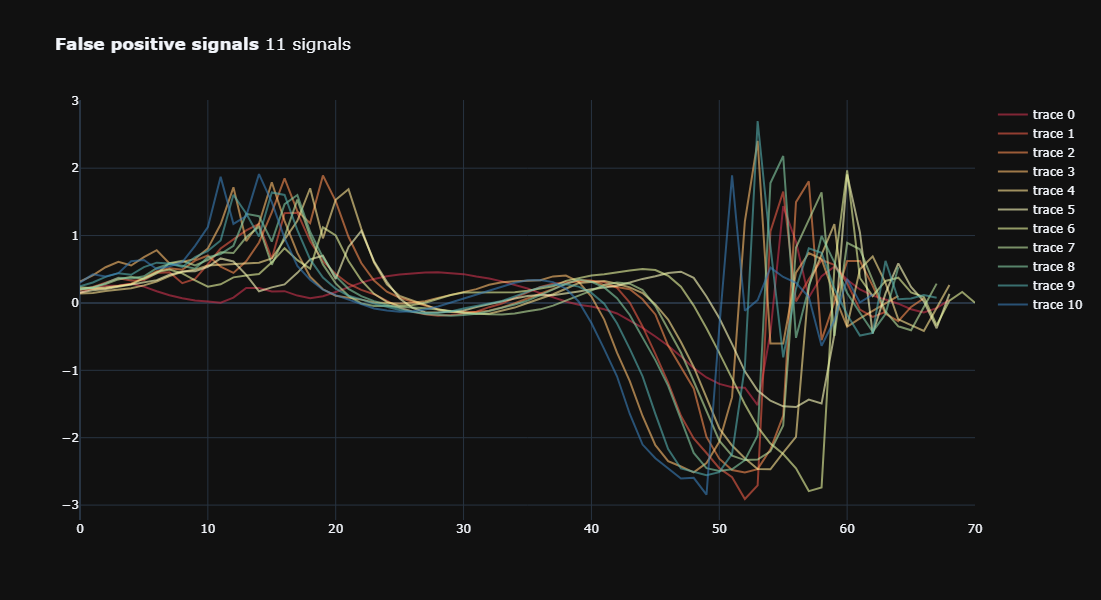

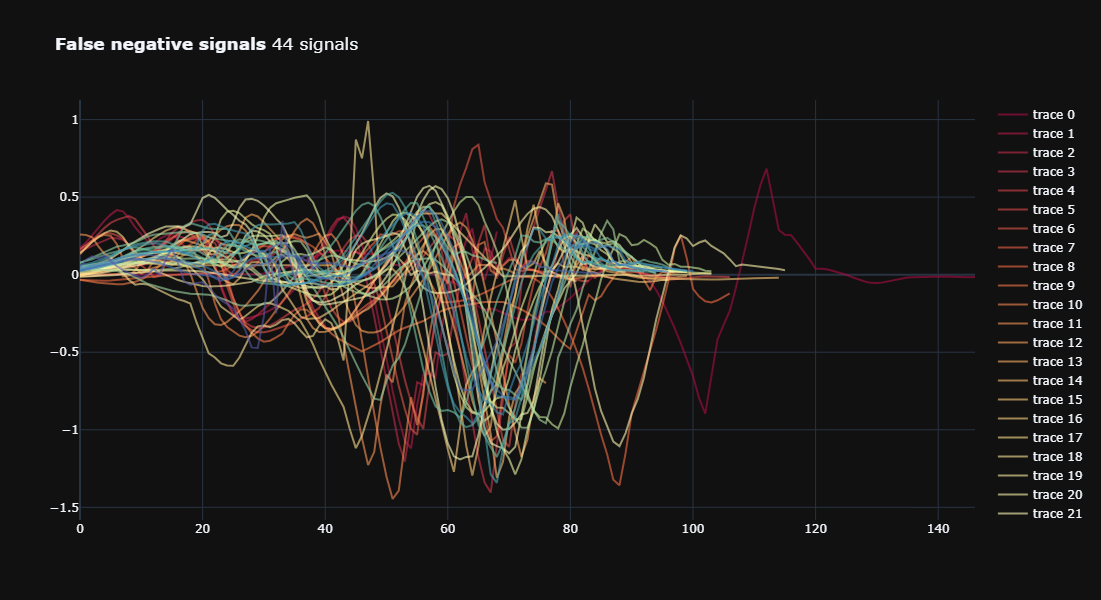

In [130]:
y_pred = get_clustering(2, X_train2, y_train, X_test2)

false_positive_mask = (y_pred==1)*(np.array(y_test)==0) == 1
false_negative_mask = (y_pred==0)*(np.array(y_test)==1) == 1

X_false_positive =  np.array(X_test)[false_positive_mask]
X_false_negative =  np.array(X_test)[false_negative_mask]


plot_all_st(X_false_positive, clustering = None, 
            title = f"<b>False positive signals</b> {len(X_false_positive)} signals")
plot_all_st(X_false_negative, clustering = None, 
            title = f"<b>False negative signals</b> {len(X_false_negative)} signals")

There is indeed more false negative signals.